<a href="https://colab.research.google.com/github/sdlm/test_cases/blob/main/Family_Office.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [7]:
import itertools
from operator import itemgetter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Autocorrelation
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

# Stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

In [8]:
import warnings
warnings.filterwarnings('once') # ignore
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=InterpolationWarning)

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [10]:
# df = pd.read_csv('./data/test_junior/test.csv')
df = pd.read_csv('/content/drive/My Drive/Family Office/test.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      200000 non-null  float64
 1   x2      200000 non-null  float64
 2   x3      200000 non-null  float64
 3   x4      200000 non-null  float64
 4   x5      200000 non-null  float64
 5   x6      200000 non-null  float64
 6   x7      200000 non-null  float64
 7   x8      200000 non-null  float64
 8   s1      200000 non-null  float64
 9   s2      200000 non-null  float64
 10  y1      200000 non-null  float64
dtypes: float64(11)
memory usage: 16.8 MB


In [12]:
feats = [f'x{i+1}' for i in range(8)]
feat_n = len(feats)
ms_feats = ['s1', 's2'] # market state
ms_feat_n = len(ms_feats)

In [13]:
# settings
folds_k = 5

# Autocorrelation

In [14]:
for i in range(feat_n):
    print(f'x{i+1}:', durbin_watson(df[f'x{i+1}'].values))

x1: 7.178579516225035e-10
x2: 6.255713613743925e-10
x3: 6.349745289087293e-10
x4: 6.979250107820972e-10
x5: 6.309026595100752e-10
x6: 3.238186618066401e-10
x7: 3.365388355145626e-10
x8: 3.087324984059089e-10


Для фич x1-x8 автокореляция отсутствует.

In [15]:
for i in range(ms_feat_n):
    print(f's{i+1}:', durbin_watson(df[f's{i+1}'].values))

s1: 0.002100143694042224
s2: 0.0018979569052137992


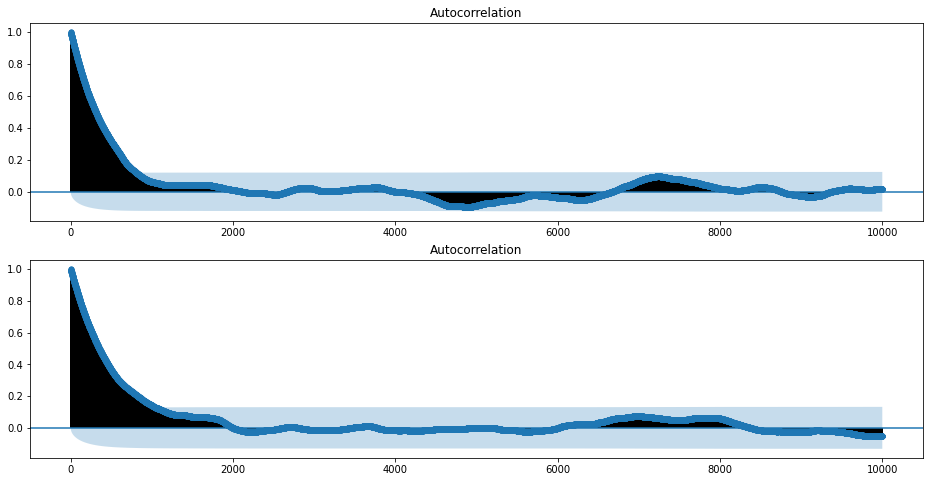

In [16]:
fig, axs = plt.subplots(ms_feat_n, figsize=(16,8))
for i in range(ms_feat_n):
    plot_acf(df[f's{i+1}'], lags=10000, ax=axs[i], alpha=0.01)

Для фич s1-s2 возможно есть некоторая автокореляция, надо исследовать дополнительно.

# Correlation between features

In [17]:
correlations = {}
for f1, f2 in itertools.combinations(feats, 2):
    correlations[f'{f1}-{f2}'] = abs(df[[f1, f2]].corr().iloc[0, 1])
for k, v in sorted(correlations.items(), key=itemgetter(1), reverse=True)[:3]:
    print(f'{k}: {v:.3f}')

x2-x7: 0.724
x7-x8: 0.694
x2-x6: 0.665


#### Lets look on top-1 correlated feats.

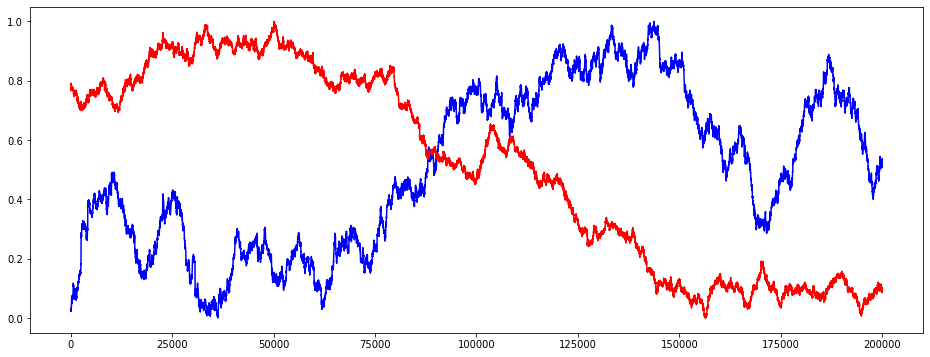

In [18]:
fig, ax = plt.subplots(1, figsize=(16,6))
scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(df[['x2', 'x7']].values)
sns.lineplot(data=data.T[0], ax=ax, color='blue')
sns.lineplot(data=data.T[1], ax=ax, color='red');

I can suggest that here is some forex-pairs with USD, lets say red- EUR/USD and blue- USD/GBP. So we can see negative correlation on news for USD and long-term USD movemet.

# Stationarity

In [21]:
def adf_test(timeseries) -> float:
    _, pvalue, _, _, _, _ = adfuller(timeseries)
    return pvalue

def kpss_test(timeseries, regression:str = 'c'):
    _, pvalue, _, _ = kpss(timeseries, regression=regression)  # , nlags="auto"
    return pvalue

In [23]:
stationary_feats = []

# Dickey-Fuller test:
# for feat in feats:
#     if adf_test(df[feat]) < 0.05:
#         print(f'Feat {feat} looks like stationar process')
#         stationary_feats.append(feat)
    
# KPSS test:
for regression in ['c', 'ct']:
    for feat in feats:
        if kpss_test(df[feat], regression=regression) < 0.05:
            pass
        else:
            print(f"Feat {feat} looks like {'constant' if regression == 'c' else 'trend'} stationar process")
            stationary_feats.append(feat)
            
if not stationary_feats:
    print('No one feat is stationarity')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


No one feat is stationarity


# Influence to target

In [24]:
# fig, axs = plt.subplots(feat_n, figsize=(16,32))
# scaler = preprocessing.MinMaxScaler()
# for i in range(feat_n):
#     data = scaler.fit_transform(df[[f'x{i+1}', 'y1']].values)
#     sns.lineplot(data=data.T[0], ax=axs[i], color='blue')
#     sns.lineplot(data=data.T[1], ax=axs[i], color='red');

In [25]:
# overall
correlations = {}
for feat in feats:
    correlations[f'{feat}-y1'] = abs(df[[feat, 'y1']].corr().iloc[0, 1])
for k, v in sorted(correlations.items(), key=itemgetter(1), reverse=True)[:3]:
    print(f'{k}: {v:.3f}')

x6-y1: 0.781
x2-y1: 0.485
x5-y1: 0.392


In [26]:
# by single support variable
for variable, value in itertools.product(['s1','s2'], [0, 1]):
    correlations = {}
    df_ = df[df[variable] == value]
    for feat in feats:
        correlations[f'{feat}-y1'] = abs(df_[[feat, 'y1']].corr().iloc[0, 1])
    print(f'\nOn case {variable} = {value} only:')
    for k, v in sorted(correlations.items(), key=itemgetter(1), reverse=True)[:3]:
        print(f'{k}: {v:.3f}')


On case s1 = 0 only:
x6-y1: 0.806
x2-y1: 0.516
x5-y1: 0.432

On case s1 = 1 only:
x6-y1: 0.754
x2-y1: 0.455
x3-y1: 0.379

On case s2 = 0 only:
x6-y1: 0.795
x8-y1: 0.434
x2-y1: 0.415

On case s2 = 1 only:
x6-y1: 0.760
x2-y1: 0.536
x5-y1: 0.462


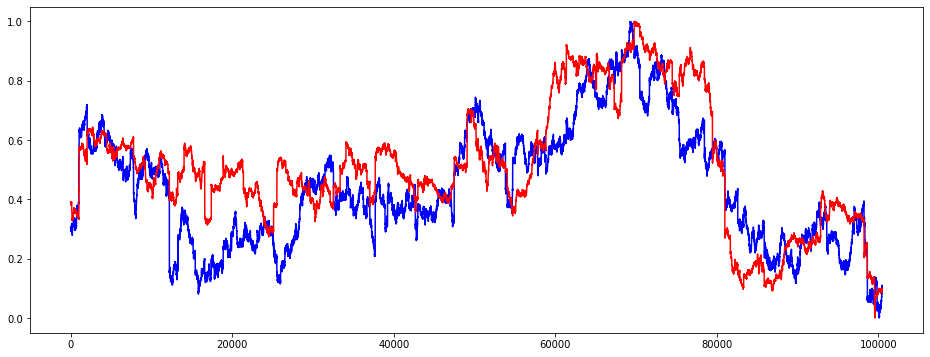

In [27]:
fig, ax = plt.subplots(1, figsize=(16,6))
scaler = preprocessing.MinMaxScaler()
df_ = df[df['s1'] == 0]
data = scaler.fit_transform(df_[['x6', 'y1']].values)
sns.lineplot(data=data.T[0], ax=ax, color='blue')
sns.lineplot(data=data.T[1], ax=ax, color='red');

In [28]:
# by single support variable
for v1, v2 in itertools.product([0, 1], [0, 1]):
    correlations = {}
    df_ = df[(df['s1'] == v1) & (df['s2'] == v2)]
    for feat in feats:
        correlations[f'{feat}-y1'] = abs(df_[[feat, 'y1']].corr().iloc[0, 1])
    print(f'\nOn case s1 = {v1} and s2 = {v2} only:')
    for k, v in sorted(correlations.items(), key=itemgetter(1), reverse=True)[:3]:
        print(f'{k}: {v:.3f}')


On case s1 = 0 and s2 = 0 only:
x6-y1: 0.839
x8-y1: 0.502
x3-y1: 0.397

On case s1 = 0 and s2 = 1 only:
x6-y1: 0.765
x2-y1: 0.625
x5-y1: 0.502

On case s1 = 1 and s2 = 0 only:
x6-y1: 0.749
x2-y1: 0.434
x3-y1: 0.381

On case s1 = 1 and s2 = 1 only:
x6-y1: 0.754
x2-y1: 0.460
x5-y1: 0.423


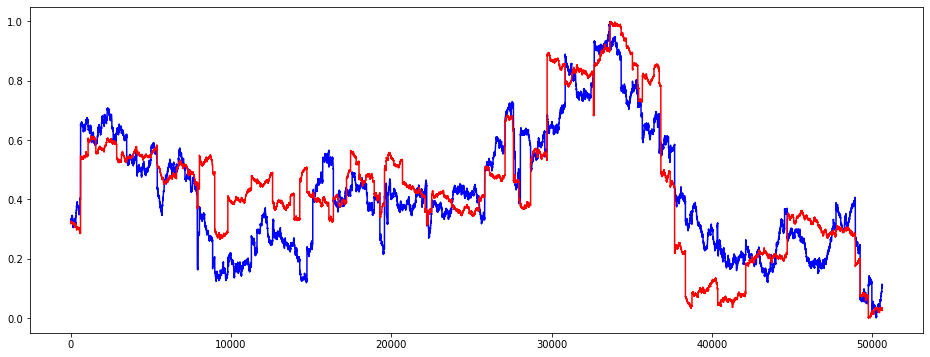

In [29]:
fig, ax = plt.subplots(1, figsize=(16,6))
scaler = preprocessing.MinMaxScaler()
df_ = df[(df['s1'] == 0) & (df['s2'] == 0)]
data = scaler.fit_transform(df_[['x6', 'y1']].values)
sns.lineplot(data=data.T[0], ax=ax, color='blue')
sns.lineplot(data=data.T[1], ax=ax, color='red');

# Feature engineering

In [30]:
feats = ['x2', 'x3', 'x4', 'x6']
# здесь выбраны наиболее перспективные фичи по результату рассчётов коэфициентов модели с L1 регуляризацией.

In [31]:
feat_lags = []
step = 4
for feat in feats:
    for shift in range(step, step * 10 + 1, step):
        new_feat_name = f'{feat}_lag_{shift}'
        vals = df[feat].values[:-shift]
        zeros = np.zeros(shift)
        df[new_feat_name] = pd.Series(np.concatenate([vals, zeros]))
        feat_lags.append(new_feat_name)

In [32]:
feat_mas = []
step = 100
for feat in feats:
    for window in range(step, step * 10 + 1, step):
        new_feat_name = f'{feat}_ma_{window}'
        df[new_feat_name] = df[feat].rolling(window=window).mean()
        df[new_feat_name] = df[new_feat_name].fillna(value=df[new_feat_name].iloc[window-1])
        feat_mas.append(new_feat_name)

In [33]:
feat_emas = []
step = 100
for feat in feats:
    for window in range(step, step * 10 + 1, step):
        new_feat_name = f'{feat}_ema_{window}'
        df[new_feat_name] = df[feat].ewm(span=window).mean()
        feat_emas.append(new_feat_name)

In [34]:
feat_directions = []
step = 10
for feat in feat_mas:
    for shift in range(step, step * 10 + 1, step):
        new_feat_name = f'{feat}_di_{shift}'
        pval = np.concatenate(
            [np.ones(shift) * df[feat].iloc[0], df[feat].values[:-shift]]
        )
        cval = df[feat].values
        df[new_feat_name] = pd.Series(data=cval + (cval - pval) / shift)
        feat_directions.append(new_feat_name)

In [35]:
feats_spec_by_1 = []
for splitter in ['s1', 's2']:
    for f1, f2 in itertools.permutations(feats, 2):
        for window in range(5000, 16000, 1000):
            new_feat_name = f'{f1}+{f2}_by_{splitter}_w{window}'
            a_new = np.where(df[splitter].values == 0, df[f1].values, df[f2].values)
            ss = pd.Series(a_new).rolling(window=window).mean()
            df[new_feat_name] = ss.fillna(value=ss[window])
            feats_spec_by_1.append(new_feat_name)

feats_spec_by_1 = ['x6+x3_by_s1_w15000', 'x3+x2_by_s2_w15000']

In [36]:
feats_spec_by_2 = []
for f1, f2, f3, f4 in itertools.permutations(feats, 4):
    for window in range(5000, 16000, 1000):
        new_feat_name = f'{f1}+{f2}_by_s1_{f3}+{f4}_by_s2_w{window}'
        a1 = np.where(df['s1'].values == 0, df[f1].values, df[f2].values)
        a2 = np.where(df['s2'].values == 0, df[f3].values, df[f4].values)
        ss = pd.Series((a1 + a2) / 2.0).rolling(window=window).mean()
        df[new_feat_name] = ss.fillna(value=ss[window])
        feats_spec_by_2.append(new_feat_name)

In [37]:
feats_extend = \
    feats \
    + feat_lags \
    + feat_mas \
    + feat_emas \
    + feat_directions \
    + feats_spec_by_1
#     + feats_spec_by_2

In [38]:
feats_extend = [
    'x6_ema_1000',
    'x6+x3_by_s1_w15000',
    'x2_ma_200',
    'x4_ema_400',
    'x3+x2_by_s2_w15000',
    'x2_ema_100',
]
# на базе предыдущих запусков без этого фильтра фич

# Problem definition in common words

Дано:
- входные признаки $a_1..a_k$,
- любые производные от входных признаков $b_1..b_m$.

Нужно определить: значение зависимой переменной $y$.

Обьединение множеств значений $a_1..a_k$ и $b_1..b_m$ обозначим через $x_1..x_n$.

Искать решение будем в виде:
$$
\dot{y} = \frac{1}{n} \sum_{k=1}^n w_k * x_k
$$

Для определения наилучшего выбора значений $w_1..w_k$ будем использовать:
$$
min_w \left( y - \dot{y} \right)^2
$$

Для решения проблем с переобучением или мультиколлинеарностью можно использовать $L_1$ или $L_2$ регуляризацию:
$$
min_w \left( y - \dot{y} \right)^2 + \alpha * L
$$

$$
L_1 = \frac{1}{n} \sum_{k=1}^n w_k
$$

$$
L_2 = \sqrt{ \sum_{k=1}^n w_k^2 }
$$

# Cross validation on time series
<img src="https://i.stack.imgur.com/fXZ6k.png" />

#### Split on train/test

In [39]:
train_size = df.shape[0] * 3 // 4
X, y = df[feats_extend].values, df['y1'].values  # feats +  + ms_feats
X_train, y_train = X[:train_size], y[:train_size].reshape(-1, 1)
X_test, y_test = X[train_size:], y[train_size:].reshape(-1, 1)

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

#### Scale

In [40]:
scaler_X = preprocessing.MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

#### Split on K-folds

In [41]:
space_bef_fir_fold = train_size // 4

fold_size = (train_size - space_bef_fir_fold) // folds_k
folds = [
    (
        space_bef_fir_fold + fold_size * i,
        space_bef_fir_fold + fold_size * (i + 1)
    )
    for i in range(folds_k)
]

In [42]:
folds

[(37500, 60000),
 (60000, 82500),
 (82500, 105000),
 (105000, 127500),
 (127500, 150000)]

# Measurements

В целом для оценки результатов любой регрессионной модели мы можем использовать такие метрики как
- R2, 
- MAE, 
- MSE, 
- RMSE,
- MAPE

У каждой из этих метрик есть свои достоинства и недостатки, и выбор конкретной метрики нужно производить исходя из бизнес требований к модели.

В качестве базового примера можно воспользоваться MSE т.к. эта дефолтная метрика для линейной регрессии и в целом наиболее популярная метрика, на мой взгляд.

# Lets make model

In [43]:
reg = linear_model.LinearRegression()
mse = 0
coefs = []
for index_from, index_to in folds:
    reg.fit(X_train[:index_from], y_train[:index_from])
    y_true = y_train[index_from:index_to]
    y_pred = reg.predict(X_train[index_from:index_to])
    mse += metrics.mean_squared_error(y_true, y_pred)
    coefs.append(reg.coef_.reshape(len(feats_extend)))
mse /= folds_k
feat_importance = pd.Series(data=sum(coefs) / folds_k, index=feats_extend).sort_values(ascending=False)
feat_importance[feat_importance > 0]

x2_ema_100     60.217466
x4_ema_400      5.393471
x6_ema_1000     5.380319
dtype: float64

Мы наблюдаем переобучение. Для устранения этой проблемы, попробуем воспользоваться $L_1$ регуляризацией.

In [44]:
reg = linear_model.Lasso(alpha=0.25, random_state=42, max_iter=5000)
mse = 0
coefs = []
for index_from, index_to in folds:
    reg.fit(X_train[:index_from], y_train[:index_from])
    y_true = y_train[index_from:index_to]
    y_pred = reg.predict(X_train[index_from:index_to])
    mse += metrics.mean_squared_error(y_true, y_pred)
    coefs.append(reg.coef_.reshape(len(feats_extend)))
mse /= folds_k
print(f'avg MSE on 5-folds: {mse:.5f}')

avg MSE on 5-folds: 54.35326


In [45]:
feat_importance = pd.Series(data=sum(coefs) / folds_k, index=feats_extend).sort_values(ascending=False)
feat_importance[feat_importance > 0]

x6_ema_1000           2.072470
x2_ma_200             1.544853
x6+x3_by_s1_w15000    1.411719
x4_ema_400            0.738135
x3+x2_by_s2_w15000    0.678617
x2_ema_100            0.434074
dtype: float64

# Check results

In [46]:
# baseline
mse = metrics.mean_squared_error(y_true=y_test[1:], y_pred=y_test[:-1])
print(f'baseline MSE: {mse:.5f}')

baseline MSE: 0.00162


In [47]:
# fit on all train data
reg = linear_model.Lasso(alpha=0.25, random_state=42, max_iter=5000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [48]:
# our model
mse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred)
print(f'our model MSE: {mse:.5f}')

our model MSE: 278.83312


Это конечно ужасные результаты. Могу лишь подчеркнуть 2 вещи:
- если к фичам добавить значения таргета за предыдушие периоды то результаты будут кардинально лучше
- кажется что какраз на отрезке времени отведённом для тестирования таргет ведёт себя несколько отличающимся образом

Наример мы можем сделать наивное предположение о том что таргет можно приблизить суммой двух фич. 

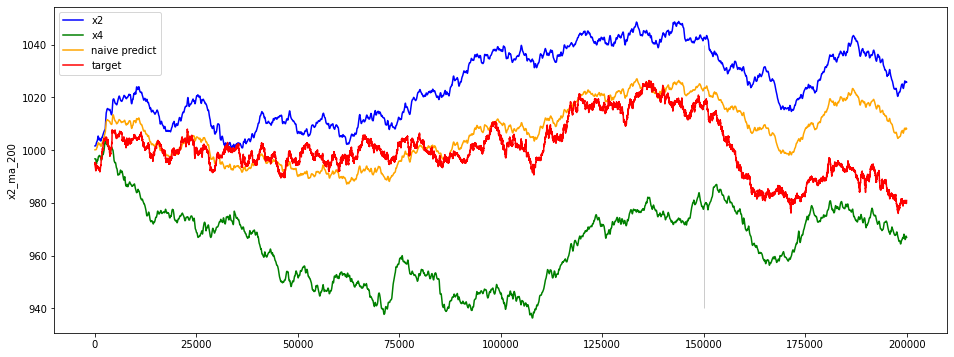

In [49]:
fig, ax = plt.subplots(1, figsize=(16,6))
sns.lineplot(data=df['x2_ma_200'], ax=ax, color='blue', label='x2')
sns.lineplot(data=df['x4_ma_200'], ax=ax, color='green', label='x4')
arr = df['x4_ma_200'].values * 0.3 + df['x2_ma_200'].values * 0.7
sns.lineplot(data=arr, ax=ax, color='orange', label='naive predict')
sns.lineplot(data=df['y1'], ax=ax, color='red', label='target')
sns.lineplot(y=[940, 1040], x=[train_size, train_size], ax=ax, color='black', linewidth=4);

# Result

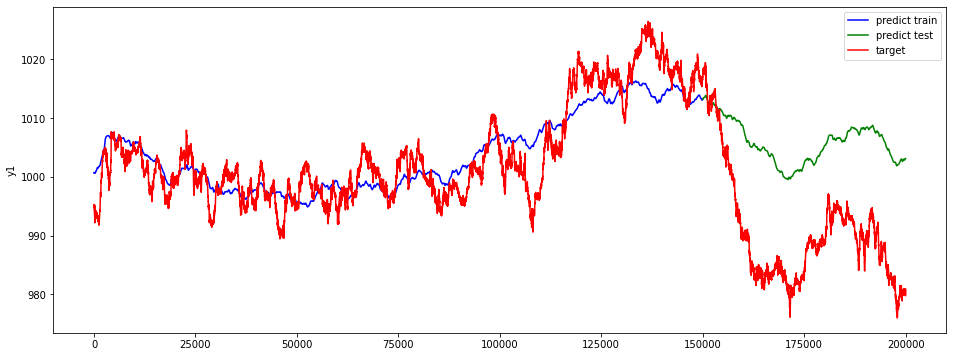

In [50]:
fig, ax = plt.subplots(1, figsize=(16,6))
sns.lineplot(x=np.arange(train_size), y=reg.predict(X_train), ax=ax, color='blue', label='predict train')
sns.lineplot(
    x=np.arange(train_size, X.shape[0]), 
    y=reg.predict(X_test), 
    ax=ax, color='green', label='predict test'
)
sns.lineplot(data=df['y1'], ax=ax, color='red', label='target');

По сути модель не справилась с довольно резким снижением в правой части.

# Model quality assessment

In [51]:
print(f'  R2: {metrics.r2_score(y_test, y_pred):.2f}')
print(f' MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f' MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}')
try:
    print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred):.2f}')
except:
    pass

  R2: -2.21
 MAE: 15.64
 MSE: 278.83
RMSE: 16.70


Полученная погрешность конечно же ужасна. Но за отведённое время эксперименты с фича-инженерингом не привели к лучшим результатам.

# Regression residual analysis

In [52]:
errors = y_test - y_pred
me = np.sum(errors) / y_test.shape[0]
print(f'Mean error: {me:.2f}')

Mean error: -15.39


Средняя ошибка сильно отличается от нуля.

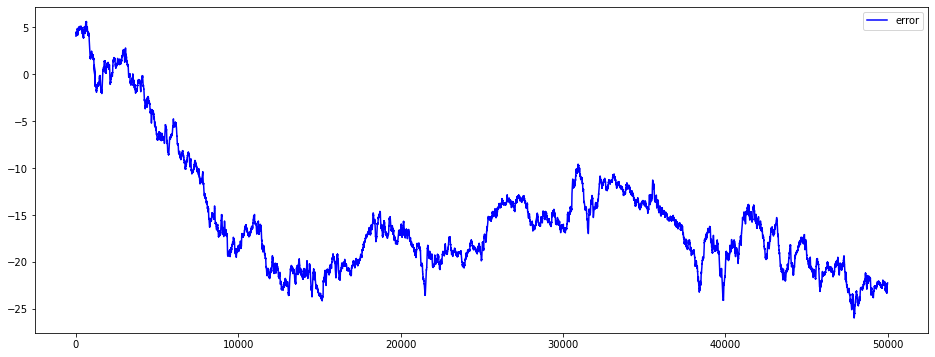

In [53]:
fig, ax = plt.subplots(1, figsize=(16,6))
sns.lineplot(x=np.arange(y_test.shape[0]), y=errors, ax=ax, color='blue', label='error');

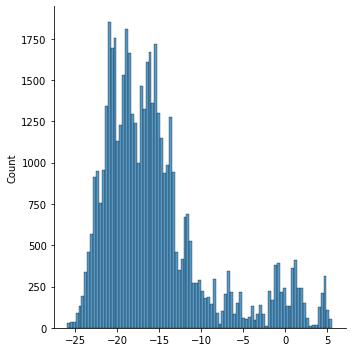

In [54]:
sns.displot(errors);

кажется что распределение имеет два пика в нуле и в -18.

In [55]:
print('Durbin-Watson statistic:', durbin_watson(errors))

Durbin-Watson statistic: 5.807353053002509e-06


кажется что ошибки не имеют автокорреляции.